# Automate the detection of brain tumors. 

Tự động hóa việc phát hiện khối u não gồm 2 phần:
- Classification: Chứa các mô hình CNN khác nhau và các mô hình transfer learning.
- Segmentation: Unet và DeepLabv3plus.  
Đưa ra dự đoán về danh sách hình ảnh và nếu hình ảnh có chứa khối u nó sẽ được chuyển tiếp đến phần phân đoạn.

In [2]:
# Tai cac thu vien can thiet
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.core import * 
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer

import glob


from tensorflow.keras.callbacks import *
# Voor GPU support

from tensorflow.keras.callbacks import *
# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data

In [3]:
path = "E:/AI_ML_DL/week 8/Brain-Tumor/brain-tumour-dataset/lgg-mri-segmentation/kaggle_3m"

In [ ]:
#toon dataset csv
#show dataset csv
data = pd.read_csv("E:/AI_ML_DL/week 8/Brain-Tumor/brain-tumour-dataset/lgg-mri-segmentation/kaggle_3m/data.csv")

In [5]:
#toon 10 rows
#show 10 rows
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

### Load images and masks


In [6]:
# Separate images and masks in the directory
masks_dir = glob.glob(path + "*/*_mask*")

images_dir = []
for img in masks_dir:
    images_dir.append(img.replace("_mask", ""))

In [7]:
# Create a new datafarme for brain images and masks
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })
data_brain.head()# Create a new datafarme for brain images and masks
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })
data_brain.head()

file_images  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                          file_masks  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [8]:
mask = cv2.imread(data_brain["file_masks"][1200])
np.max(mask) 

0

In [9]:
mask = cv2.imread(data_brain["file_masks"][12])
np.max(mask) 

0

In [10]:
# diagnosis: chuẩn đoán
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 1
    else:
        return 0

In [11]:
data_brain["mask"] = data_brain["file_masks"].apply(lambda x: positive_negative_diagnosis(x))

In [12]:
# 0 -> non tumor , 1 -> tumor
data_brain


file_images  \
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                             file_masks  mask  
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
...                                                 ...   ...  
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  

[3929 rows x 3 columns]

In [13]:
data_brain["mask"].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

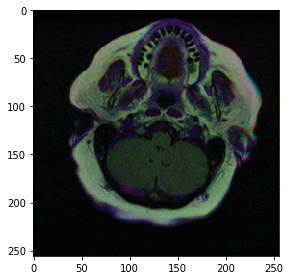

In [14]:
#print one image
image = io.imread(data_brain.file_images[1])
imshow(image)
plt.show()

In [15]:
def show_image(df):
    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(20, 40))
    count = 0
    i = 0
    for mask in df["mask"]:
        if mask == 1:
            # Show images
            image = io.imread(df.file_images[i])
            ax[count][0].title.set_text("Brain MRI")
            ax[count][0].imshow(image)

            # Show masks
            mask = io.imread(df.file_masks[i])
            ax[count][1].title.set_text("Mask Brain MRI")
            ax[count][1].imshow(mask, cmap="gray")

            # Show MRI Brain with mask
            image[mask == 255] = (0, 255, 0)    # Here, we want to modify the color of pixel at the position of mask
            ax[count][2].title.set_text("MRI Brain with mask")
            ax[count][2].imshow(image)
            count += 1
            i += 1
        if count == 10:
            break
    fig.tight_layout()
    plt.show()

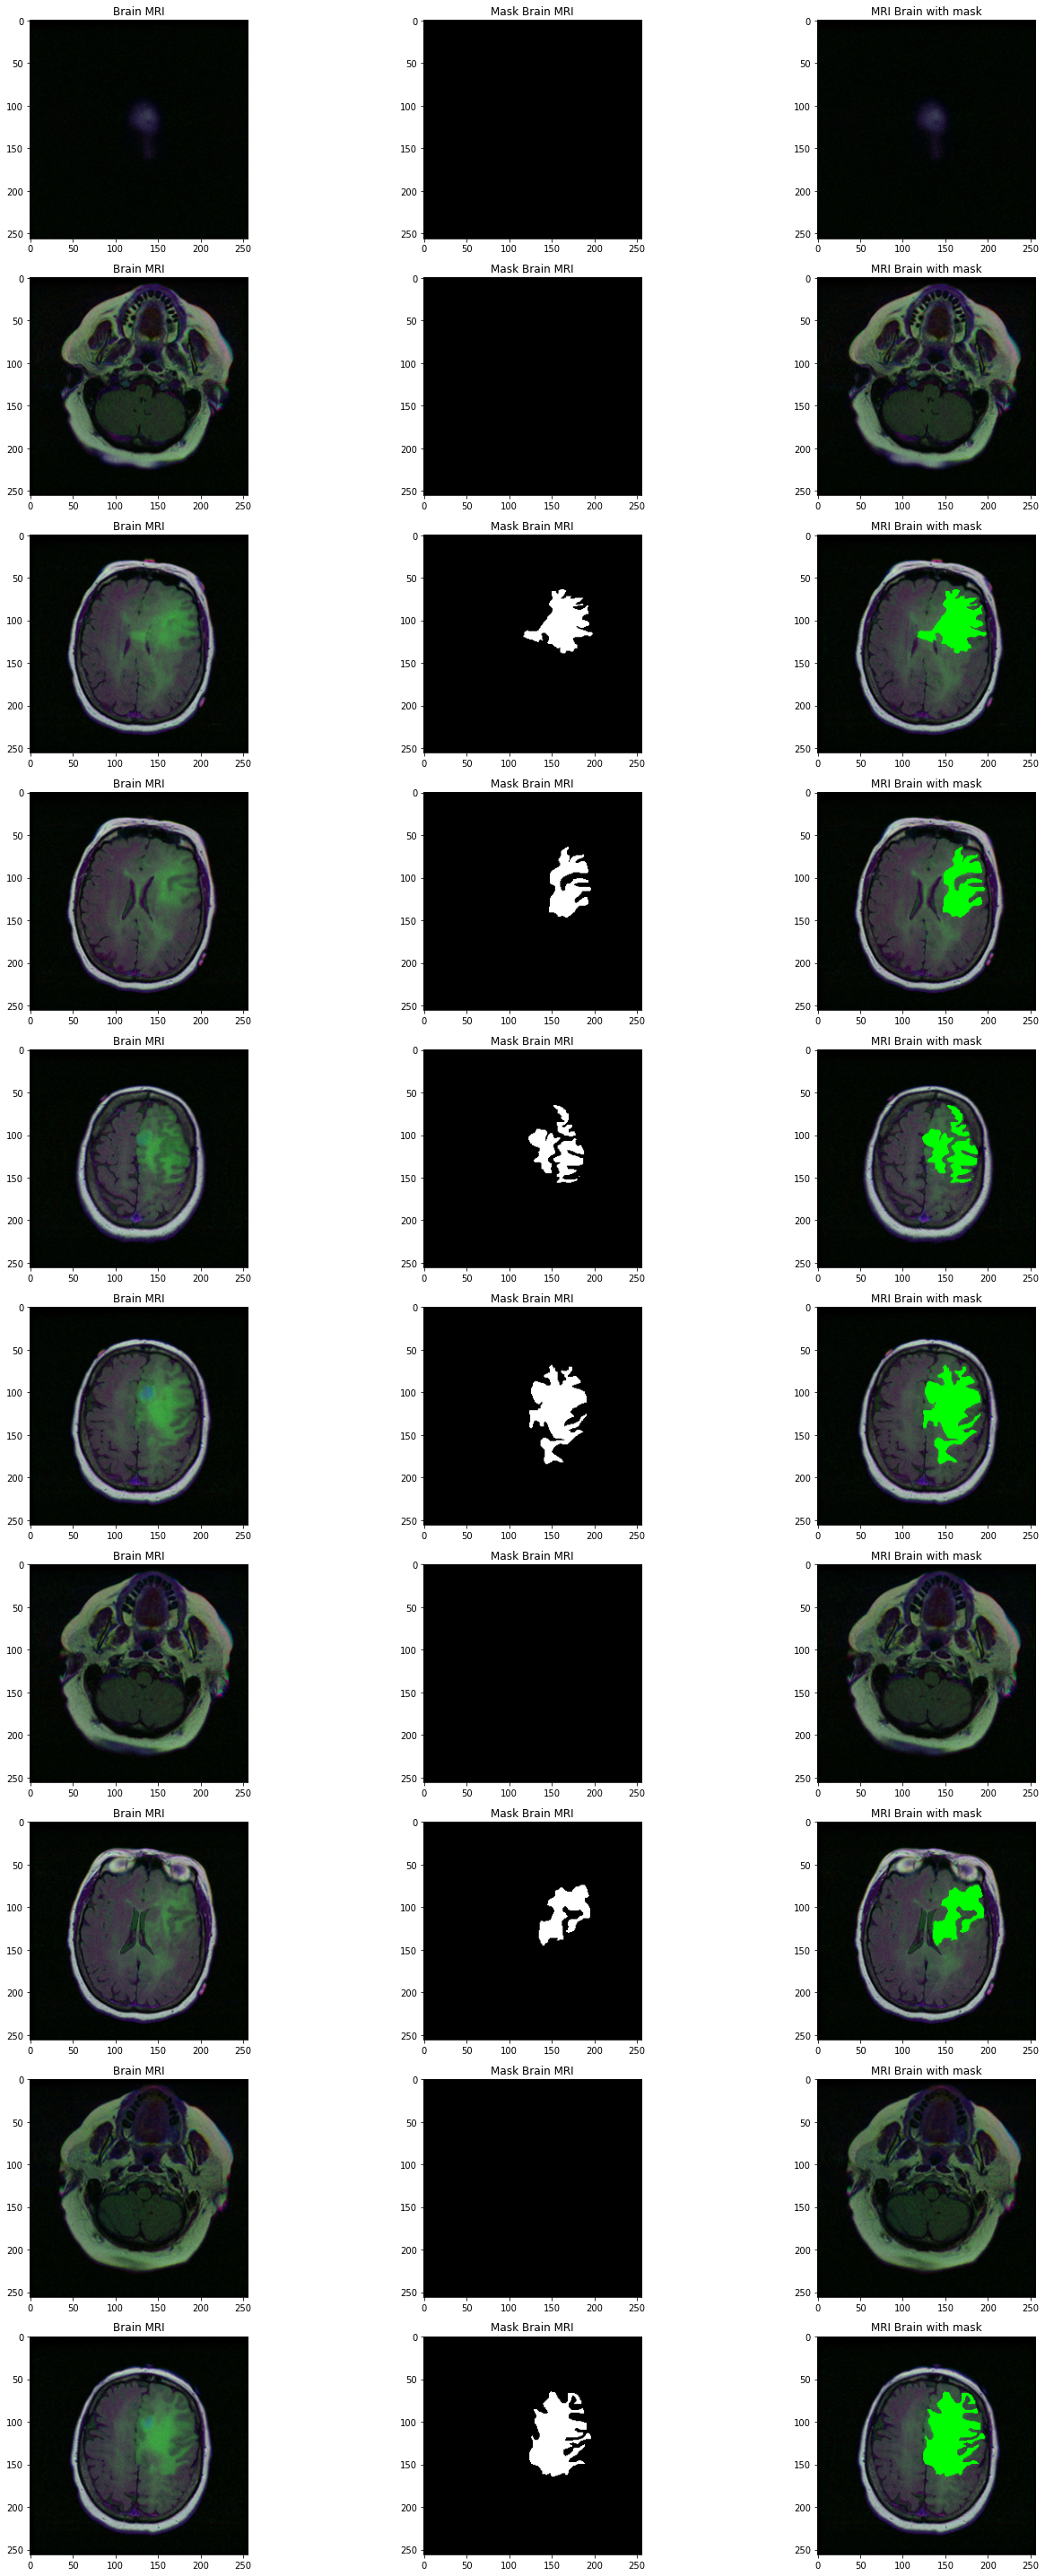

In [16]:
show_image(data_brain)

In [17]:
#split dataset in tumor and without
data_brain_with = data_brain[data_brain['mask'] == 1].values
data_brain_without = data_brain[data_brain['mask'] == 0].values

In [18]:
# Create the pandas DataFrame
data_brain_with = pd.DataFrame(data_brain_with, columns = ['file_images','file_masks','mask'])
data_brain_with

file_images  \
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
1368  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1369  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1370  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1371  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1372  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                             file_masks mask  
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
...                                                 ...  ...  
1368  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1369  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1370  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1371  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1372  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  

[1373 rows x 3 columns]

In [19]:
data_brain_without = pd.DataFrame(data_brain_without, columns = ['file_images','file_masks','mask'])


In [20]:
data_brain_with.file_images[0]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif'

In [21]:
data_brain_without.head()

file_images  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                          file_masks mask  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0

### Separate X, y


In [22]:
# change every row to array (brain_image_with)

brain_image_with = []
y_brain_with = []
image_size = 128

def to_array_with(df):
    count = 0
    i = 0
    for mask in df["mask"]:
        # Show images
       
        image = imread(df.file_images[i])
    
        image = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        brain_image_with.append(image)

        # Show images     
        y_brain_with.append(1)
        
        count += 1
        i += 1
        if count == 1373:
            break

            
to_array_with(data_brain_with)


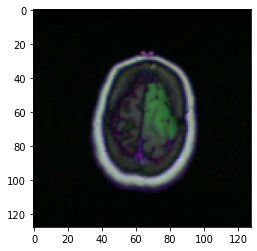

In [23]:
plt.imshow(brain_image_with[12]) 

In [24]:
print(y_brain_with)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [25]:
# change every row to array(brain_image_without)
brain_image_without = []
y_brain_without = []
image_size = 128

def to_array_without(df):
    count = 0
    i = 0
    for mask in df["mask"]:
        # Show images
        image = io.imread(df.file_images[i])
        
        image = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        brain_image_without.append(image)

        # Show images
        #image = io.imread(df.file_masks[i])
        #y_brain_image_without.append(image)
        y_brain_without.append(0)

        
        count += 1
        i += 1
            
        if count == 1373: # to balance with data_brain_with
            break
to_array_without(data_brain_without)

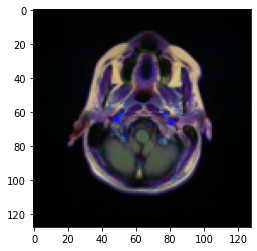

In [26]:
plt.imshow(brain_image_without[132])

In [27]:
print(y_brain_without)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
# class balance 

print("without tumor:",len(brain_image_without))
print("with tumor:", len(brain_image_with))

without tumor: 1373
with tumor: 1373


In [29]:
# Create a training set and test set. Make sure the datasets are randomized.

X = np.vstack((np.asarray(brain_image_without),np.asarray(brain_image_with)))
y = np.hstack((np.asarray(y_brain_without),np.asarray(y_brain_with)))

In [30]:
print(X.shape)

(2746, 128, 128, 3)


In [31]:
print(y.shape)

(2746,)


In [32]:
# balancedness of the dataset
label_count = np.bincount(y)

print('count class 0: ',label_count[0])
print('count class 1: ',label_count[1])
print('ratio: ',label_count[0]/label_count[1])


count klasse 0:  1373
count klasse 1:  1373
ratio:  1.0


### Training split


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state =0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state =0)

In [34]:
# balancedness of the dataset
label_count = np.bincount(y_train)

print('count class 0: ',label_count[0])
print('count class 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])

count klasse 0:  1053
count klasse 1:  1047
ratio:  1.005730659025788


In [35]:
y_train

array([0, 0, 0, ..., 1, 1, 0])

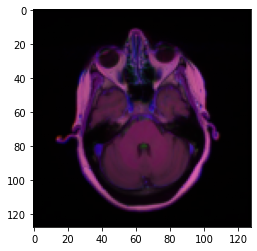

In [36]:
img = X_train[6]
plt.imshow(img)

In [37]:
print(X_val)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [38]:
# Image normalization when necessary

# Normalisatie
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
#X_train /= 255 
#X_test /= 255

#original test labels -> for prediction
y_test_original = y_test
y_train_original = y_train
y_val_original = y_val

# one-hot encoding of the target labels
y_train = to_categorical(y_train) # only on training labels
y_test = to_categorical(y_test) 
y_val = to_categorical(y_val)



### read datafile -> X_train, X_test,.....

In [39]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)

(2100, 128, 128, 3)
(2100, 2)
(275, 128, 128, 3)
(275, 2)
(371, 128, 128, 3)
(371, 2)


In [40]:
# balancedness of the dataset
label_count = np.bincount(y_train_original)

print('count class 0: ',label_count[0])
print('count class 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])


count klasse 0:  1053
count klasse 1:  1047
ratio:  1.005730659025788


## Classification - Convolutional neural network

### Model

In [41]:
%%time
# Neural network

checkpoint_filepath = 'E:/AI_ML_DL/week 8/Brain-Tumor/Classification_brain_best.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# Neural network parameters
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3) # 1 -> grijs waarden, 3 -> kleur
epochs = 500
batch_size = 32

# Layers

OwnClassificationNN=Sequential()

OwnClassificationNN.add(Conv2D(256,(3,3),input_shape=input_shape))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(BatchNormalization())
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))


OwnClassificationNN.add(Dropout(0.1))


OwnClassificationNN.add(Conv2D(128,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN.add(Conv2D(64,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(BatchNormalization())
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))


OwnClassificationNN.add(Dropout(0.3))

OwnClassificationNN.add(Conv2D(16,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN.add(Conv2D(8,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))


#Fully Connected
OwnClassificationNN.add(Flatten())
OwnClassificationNN.add(Dropout(0.1)) 
OwnClassificationNN.add(Dense(4,activation='relu'))
OwnClassificationNN.add(Dense(num_classes,activation='softmax'))


OwnClassificationNN.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# Training the CNN
history = OwnClassificationNN.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_val,y_val) ,verbose=1,callbacks=[es,mc])


2022-01-19 14:26:22.082590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-19 14:26:22.085917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 14:26:22.086710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 14:26:22.087345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/500


2022-01-19 14:26:26.274151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


66/66 [==============================] - 12s 73ms/step - loss: 0.6589 - accuracy: 0.5810 - val_loss: 0.7894 - val_accuracy: 0.5256
Epoch 2/500
66/66 [==============================] - 4s 55ms/step - loss: 0.5951 - accuracy: 0.6614 - val_loss: 0.6879 - val_accuracy: 0.5256
Epoch 3/500
66/66 [==============================] - 4s 55ms/step - loss: 0.4647 - accuracy: 0.7724 - val_loss: 0.7862 - val_accuracy: 0.5256
Epoch 4/500
66/66 [==============================] - 4s 55ms/step - loss: 0.4338 - accuracy: 0.7829 - val_loss: 0.6549 - val_accuracy: 0.5499
Epoch 5/500
66/66 [==============================] - 4s 55ms/step - loss: 0.4088 - accuracy: 0.7943 - val_loss: 0.6747 - val_accuracy: 0.5553
Epoch 6/500
66/66 [==============================] - 4s 54ms/step - loss: 0.3912 - accuracy: 0.8057 - val_loss: 0.7106 - val_accuracy: 0.5472
Epoch 7/500
66/66 [==============================] - 4s 54ms/step - loss: 0.3457 - accuracy: 0.8143 - val_loss: 0.5692 - val_accuracy: 0.7089
Epoch 8/500
66/66

In [42]:
OwnClassificationNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 256)     7168      
_________________________________________________________________
activation (Activation)      (None, 126, 126, 256)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 256)     1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       295040    
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 128)       0

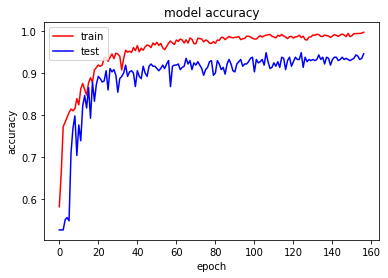

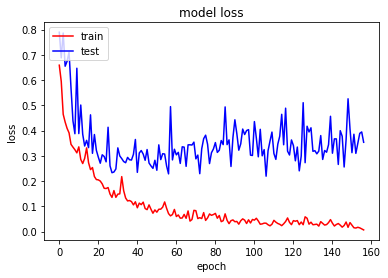

In [43]:
# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
OwnClassificationNN.load_weights(checkpoint_filepath)


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
OwnClassificationNN.save("E:/AI_ML_DL/week 8/Brain-Tumor/Model/OwnClassificationNN.h5")


y_pred = np.argmax(OwnClassificationNN.predict(X_test), axis=-1)


print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 




              precision    recall  f1-score   support

           0       0.94      0.97      0.96       144
           1       0.97      0.93      0.95       131

    accuracy                           0.95       275
   macro avg       0.95      0.95      0.95       275
weighted avg       0.95      0.95      0.95       275

[[140   4]
 [  9 122]]
95.27272727272728


In [45]:
print(OwnClassificationNN.evaluate(X_test,y_test))

9/9 [==============================] - 0s 14ms/step - loss: 0.1354 - accuracy: 0.9527
[0.1354370415210724, 0.9527272582054138]


### Augmentation with own  classification model 

In [46]:
# Neural network
checkpoint_filepath_Class_aug = 'E:/AI_ML_DL/week 8/Brain-Tumor/Classification_brain_best_augmen.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_Class_aug,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

# Neural network parameters
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3) # 1 -> grijs waarden, 3 -> kleur
epochs = 500
batch_size = 64

# Layers
OwnClassificationNN_aug=Sequential()


OwnClassificationNN_aug.add(Conv2D(256,(3,3),input_shape=input_shape))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(BatchNormalization())
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))


OwnClassificationNN_aug.add(Dropout(0.1))

OwnClassificationNN_aug.add(Conv2D(128,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN_aug.add(Conv2D(64,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(BatchNormalization())
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))


OwnClassificationNN_aug.add(Dropout(0.3))

OwnClassificationNN_aug.add(Conv2D(16,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN_aug.add(Conv2D(8,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))


# Fully Connected
OwnClassificationNN_aug.add(Flatten())
OwnClassificationNN_aug.add(Dropout(0.2)) 
OwnClassificationNN_aug.add(Dense(4,activation='relu'))
OwnClassificationNN_aug.add(Dense(num_classes,activation='softmax'))
OwnClassificationNN_aug.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])


# Image augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="nearest")
 
# train the network
history_aug = OwnClassificationNN_aug.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),callbacks=[es,mc],verbose=1,
steps_per_epoch=len(X_train) // batch_size, epochs=epochs,validation_data = (X_val,y_val))



/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
32/32 [==============================] - 12s 307ms/step - loss: 0.7227 - accuracy: 0.5324 - val_loss: 0.6911 - val_accuracy: 0.5687
Epoch 2/500
32/32 [==============================] - 8s 258ms/step - loss: 0.6759 - accuracy: 0.5599 - val_loss: 0.6880 - val_accuracy: 0.5741
Epoch 3/500
32/32 [==============================] - 8s 256ms/step - loss: 0.6615 - accuracy: 0.5889 - val_loss: 0.6918 - val_accuracy: 0.5256
Epoch 4/500
32/32 [==============================] - 9s 276ms/step - loss: 0.6555 - accuracy: 0.5855 - val_loss: 0.6918 - val_accuracy: 0.5256
Epoch 5/500
32/32 [==============================] - 8s 259ms/step - loss: 0.6505 - accuracy: 0.5982 - val_loss: 0.6919 - val_accuracy: 0.5256
Epoch 6/500
32/32 [==============================] - 8s 261ms/step - loss: 0.6257 - accuracy: 0.6503 - val_loss: 0.6856 - val_accuracy: 0.5687
Epoch 7/500
32/32 [==============================] - 9s 265ms/step - loss: 0.6298 - accuracy: 0.6636 - val_loss: 0.6773 - val_accuracy: 0.598

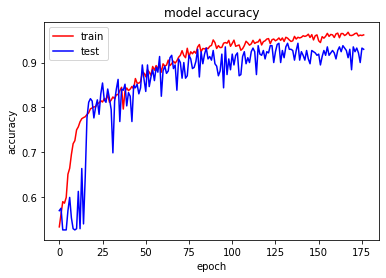

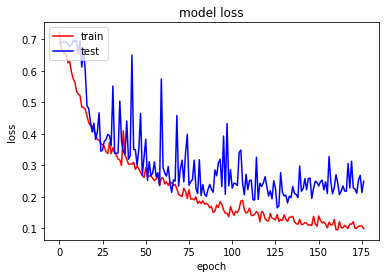

In [47]:
# Accuray 
plt.plot(history_aug.history['accuracy'],'r')
plt.plot(history_aug.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history_aug.history['loss'],'r')
plt.plot(history_aug.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
OwnClassificationNN_aug.load_weights(checkpoint_filepath_Class_aug)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
OwnClassificationNN_aug.save("E:/AI_ML_DL/week 8/Brain-Tumor/Model/OwnClassificationNN_aug.h5")

y_pred = np.argmax(OwnClassificationNN_aug.predict(X_test), axis=-1)


print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       144
           1       0.98      0.96      0.97       131

    accuracy                           0.97       275
   macro avg       0.98      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275

[[142   2]
 [  5 126]]
97.45454545454545


## Transfer learning classification

### EfficientNetB0

In [49]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
# X = Dropout(0.2) # ---->> to avoid overfitting 
# x = Dense(8, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)  
EfficientNetB0 = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model 
EfficientNetB0.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint_filepath_transfer_EfficientNetB0 = 'E:/AI_ML_DL/week 8/Brain-Tumor/bestmodel_brain_transfer_EfficientNetB0.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_EfficientNetB0,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


batch_size =64
epochs = 50
history = EfficientNetB0.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/50
33/33 [==============================] - 8s 91ms/step - loss: 0.7086 - accuracy: 0.5133 - val_loss: 0.6955 - val_accuracy: 0.5256
Epoch 2/50
33/33 [==============================] - 1s 41ms/step - loss: 0.7069 - accuracy: 0.4886 - val_loss: 0.7225 - val_accuracy: 0.4744
Epoch 3/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6993 - accuracy: 0.4976 - val_loss: 0.6938 - val_accuracy: 0.4744
Epoch 4/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6966 - accuracy: 0.4967 - val_loss: 0.6980 - val_accuracy: 0.4744
Epoch 5/50
33/33 [==============================] - 1s 43ms/step - loss: 0.7076 - accuracy: 0.5038 - val_loss: 0.7235 - val_accuracy: 0.4744
Epoch 6/50
33/33 [==============================] - 1s 39ms/step - loss: 0.7036 - accuracy: 0.5014 - val_loss: 0.6977 - val_accuracy: 0.5256
Epoch 7/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6999 - accurac

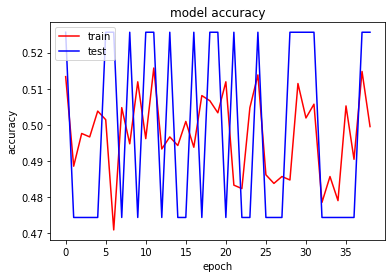

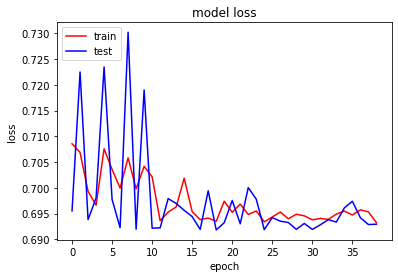

In [50]:
# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
EfficientNetB0.load_weights(checkpoint_filepath_transfer_EfficientNetB0)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
EfficientNetB0.save("E:/AI_ML_DL/week 8/Brain-Tumor/Model/EfficientNetB0.h5")


y_pred = np.argmax(EfficientNetB0.predict(X_test), axis=-1)

print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf) 
print(accuracy_score(y_test_original, y_pred) * 100) 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)




              precision    recall  f1-score   support

           0       0.00      0.00      0.00       144
           1       0.48      1.00      0.65       131

    accuracy                           0.48       275
   macro avg       0.24      0.50      0.32       275
weighted avg       0.23      0.48      0.31       275

[[  0 144]
 [  0 131]]
47.63636363636364


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionV3

In [52]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
X = Dropout(0.3) 
x = Dense(16, activation='relu')(x)
X = Dropout(0.1) 
predictions = Dense(2, activation='softmax')(x)

InceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model 
InceptionV3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_filepath_transfer_InceptionV3 = './bestmodel_brain_transfer_InceptionV3'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_InceptionV3,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

batch_size =64
epochs = 50
history = InceptionV3.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/50
33/33 [==============================] - 8s 106ms/step - loss: 0.5114 - accuracy: 0.7562 - val_loss: 0.4040 - val_accuracy: 0.8194
Epoch 2/50
33/33 [==============================] - 1s 44ms/step - loss: 0.3656 - accuracy: 0.8286 - val_loss: 0.3683 - val_accuracy: 0.8086
Epoch 3/50
33/33 [==============================] - 1s 45ms/step - loss: 0.3066 - accuracy: 0.8614 - val_loss: 0.3468 - val_accuracy: 0.8410
Epoch 4/50
33/33 [==============================] - 1s 44ms/step - loss: 0.2636 - accuracy: 0.8895 - val_loss: 0.3509 - val_accuracy: 0.8491
Epoch 5/50
33/33 [==============================] - 1s 44ms/step - loss: 0.2317 - accuracy: 0.9076 - val_loss: 0.4044 - val_accuracy: 0.8275
Epoch 6/50
33/33 [==============================] - 2s 48ms/step - loss: 0.2156 - accuracy: 0.9090 - val_loss: 0.3523 - val_accuracy: 0.8571
Epoch 7/50
33/33 [==============================] - 1s 44ms/step - loss: 0.1832 - accura

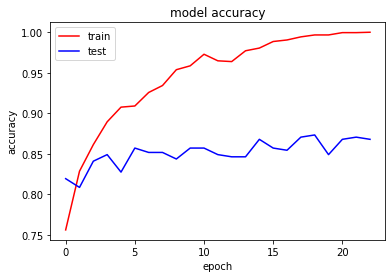

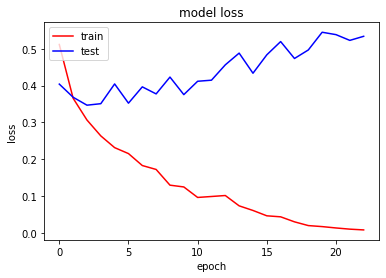

In [53]:
# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
InceptionV3.load_weights(checkpoint_filepath_transfer_InceptionV3)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
InceptionV3.save("E:/AI_ML_DL/week 8/Brain-Tumor/Model/InceptionV3.h5")


y_pred = np.argmax(InceptionV3.predict(X_test), axis=-1)

print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 




              precision    recall  f1-score   support

           0       0.93      0.72      0.81       144
           1       0.75      0.94      0.84       131

    accuracy                           0.83       275
   macro avg       0.84      0.83      0.82       275
weighted avg       0.85      0.83      0.82       275

[[104  40]
 [  8 123]]
82.54545454545455


### ResNet50

In [55]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
X = Dropout(0.2)
x = Dense(4, activation='relu')(x)
X = Dropout(0.2)
predictions = Dense(2, activation='softmax')(x)

ResNet50 = Model(inputs=base_model.input, outputs=predictions)


# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model 
ResNet50.compile(optimizer="Adam", loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_filepath_transfer_ResNet50 = 'E:/AI_ML_DL/week 8/Brain-Tumor/bestmodel_brain_transfer_resnet50'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_ResNet50,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


batch_size =32
epochs = 200
history = ResNet50.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])



94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/200
66/66 [==============================] - 6s 51ms/step - loss: 0.6872 - accuracy: 0.5414 - val_loss: 0.6740 - val_accuracy: 0.5310
Epoch 2/200
66/66 [==============================] - 2s 33ms/step - loss: 0.6757 - accuracy: 0.5743 - val_loss: 0.6807 - val_accuracy: 0.5283
Epoch 3/200
66/66 [==============================] - 2s 32ms/step - loss: 0.6626 - accuracy: 0.6267 - val_loss: 0.6612 - val_accuracy: 0.5903
Epoch 4/200
66/66 [==============================] - 2s 32ms/step - loss: 0.6500 - accuracy: 0.6552 - val_loss: 0.6390 - val_accuracy: 0.6792
Epoch 5/200
66/66 [==============================] - 2s 32ms/step - loss: 0.6407 - accuracy: 0.6724 - val_loss: 0.6401 - val_accuracy: 0.6226
Epoch 6/200
66/66 [==============================] - 2s 34ms/step - loss: 0.6361 - accuracy: 0.6600 - val_loss: 0.6235 - val_accuracy: 0.6846
Epoch 7/200
66/66 [==============================] - 2s 34ms/step - loss: 0.6276 - 

In [56]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
ResNet50.load_weights(checkpoint_filepath_transfer_ResNet50)


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
ResNet50.save("./Model/ResNet50.h5")

y_pred = np.argmax(ResNet50.predict(X_test), axis=-1)

print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 



              precision    recall  f1-score   support

           0       0.82      0.81      0.81       144
           1       0.79      0.80      0.80       131

    accuracy                           0.80       275
   macro avg       0.80      0.80      0.80       275
weighted avg       0.80      0.80      0.80       275

[[116  28]
 [ 26 105]]
80.36363636363636


### VGG19

In [57]:
# transfer learning
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3)) #input shape niet vergeten te veranderen
type(modelVGG19)

VGG19 = Sequential()

for layer in modelVGG19.layers[:]:
    VGG19.add(layer)

VGG19.summary()


for layer in VGG19.layers:
    layer.trainable = False


# FC
VGG19.add(Flatten())
VGG19.add(Dense(num_classes,activation='softmax'))


80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_______________________________________________________

In [58]:
VGG19.compile(loss='categorical_crossentropy',optimizer =adam,metrics=['accuracy'])
VGG19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)      

In [59]:
%%time
# Train VGG model
# Model checkpoint

checkpoint_filepath_transfer_VVG19 = 'E:/AI_ML_DL/week 8/Brain-Tumor/bestmodel_brain_transfer_VVG19'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_VVG19,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30)


batch_size =32
epochs = 500
history = VGG19.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])

Epoch 1/500
66/66 [==============================] - 6s 62ms/step - loss: 0.4983 - accuracy: 0.7495 - val_loss: 0.3932 - val_accuracy: 0.8059
Epoch 2/500
66/66 [==============================] - 2s 32ms/step - loss: 0.3707 - accuracy: 0.8229 - val_loss: 0.3592 - val_accuracy: 0.8410
Epoch 3/500
66/66 [==============================] - 2s 32ms/step - loss: 0.3258 - accuracy: 0.8524 - val_loss: 0.3404 - val_accuracy: 0.8410
Epoch 4/500
66/66 [==============================] - 2s 32ms/step - loss: 0.2895 - accuracy: 0.8748 - val_loss: 0.3714 - val_accuracy: 0.8221
Epoch 5/500
66/66 [==============================] - 2s 32ms/step - loss: 0.2872 - accuracy: 0.8681 - val_loss: 0.3280 - val_accuracy: 0.8518
Epoch 6/500
66/66 [==============================] - 2s 33ms/step - loss: 0.2527 - accuracy: 0.8967 - val_loss: 0.3186 - val_accuracy: 0.8464
Epoch 7/500
66/66 [==============================] - 2s 32ms/step - loss: 0.2244 - accuracy: 0.9186 - val_loss: 0.2944 - val_accuracy: 0.8679
Epoch 

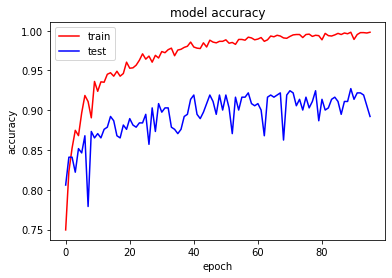

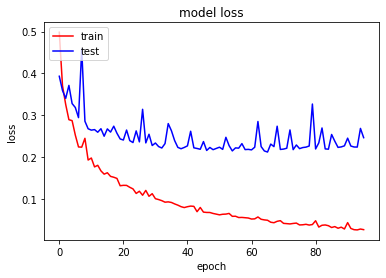

In [60]:
# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
VGG19.load_weights(checkpoint_filepath_transfer_VVG19)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
VGG19.save("E:/AI_ML_DL/week 8/Brain-Tumor/Model/VGG19.h5")


y_pred = np.argmax(VGG19.predict(X_test), axis=-1)


print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 




              precision    recall  f1-score   support

           0       0.94      0.94      0.94       144
           1       0.93      0.93      0.93       131

    accuracy                           0.93       275
   macro avg       0.93      0.93      0.93       275
weighted avg       0.93      0.93      0.93       275

[[135   9]
 [  9 122]]
93.45454545454545


## Tumor Segmentation

### Data pre-processing

In [62]:
# Dice coefficient loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [63]:
brain_df_mask = data_brain[data_brain['mask'] == 1]

In [64]:
# Create the pandas DataFrame
brain_df_mask = pd.DataFrame(data_brain_with, columns = ['file_images','file_masks','mask'])
brain_df_mask


file_images  \
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
1368  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1369  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1370  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1371  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1372  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                             file_masks mask  
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
...                                                 ...  ...  
1368  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1369  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1370  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1371  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
1372  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  

[1373 rows x 3 columns]

In [65]:
brain_df_mask.file_images[1]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif'

In [66]:
#set the mask on the image. (to predict)
brain_tumor_mask = []

def image_merge(df):
    count = 0
    i = 0
    image_size=256
    for mask in df["mask"]:
        if mask == 1:
            # Show images
            image = io.imread(df.file_images[i])
            
            # Show masks
            mask = io.imread(df.file_masks[i])
            
            # merge MRI Brain with mask
            image[mask == 255] = (0, 255, 0)    # Here, we want to modify the color of pixel at the position of mask
            brain_tumor_mask.append(image)
           
            count += 1
            i += 1
        if count == 1373:
            break


In [67]:
image_merge(brain_df_mask)

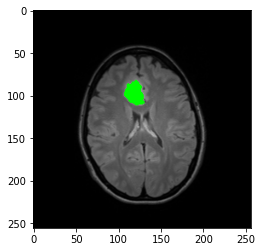

In [68]:
plt.imshow(brain_tumor_mask[100]) 

In [69]:
#resize to 128
brain_tumor_mask_resized = []
for image in brain_tumor_mask:
        resized = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        brain_tumor_mask_resized.append(resized)
        
brain_tumor_mask = brain_tumor_mask_resized

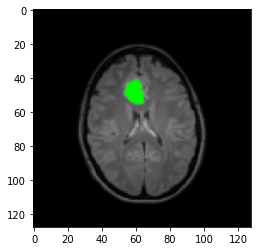

In [70]:
plt.imshow(brain_tumor_mask[100]) 

In [71]:
len(brain_tumor_mask)

1373

In [72]:
len(brain_image_with)

1373

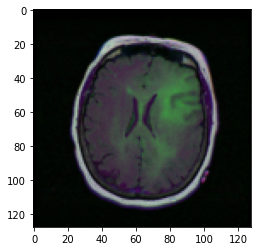

In [73]:
plt.imshow(brain_image_with[1])

In [74]:
# to array
brain_tumor_mask = np.asarray(brain_tumor_mask)
X = np.asarray(brain_image_with)


In [75]:
brain_tumor_mask

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [76]:
X

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

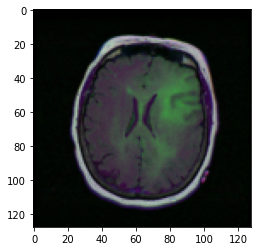

In [77]:
plt.imshow(X[1])

In [78]:
X_train_with_mask, X_test_with_mask, y_train_with_mask, y_test_with_mask = train_test_split(X, brain_tumor_mask, test_size = 0.1, random_state =0)
X_train_with_mask, X_val_with_mask, y_train_with_mask, y_val_with_mask = train_test_split(X_train_with_mask, y_train_with_mask, test_size = 0.1, random_state =0)


In [79]:
X_train_with_mask = X_train_with_mask.astype('float32')
X_test_with_mask = X_test_with_mask.astype('float32')
X_val_with_mask = X_val_with_mask.astype('float32')

y_train_with_mask = y_train_with_mask.astype('float32')
y_test_with_mask = y_test_with_mask.astype('float32')
y_val_with_mask = y_val_with_mask.astype('float32')



In [80]:
print(X_train_with_mask.shape)
print(y_train_with_mask.shape)

print(X_test_with_mask.shape)
print(y_test_with_mask.shape)

print(X_val_with_mask.shape)
print(y_val_with_mask.shape)

(1111, 128, 128, 3)
(1111, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(124, 128, 128, 3)
(124, 128, 128, 3)


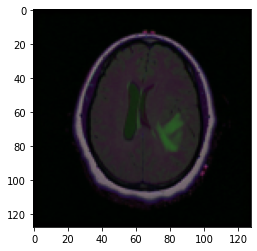

In [81]:
plt.imshow(X_val_with_mask[6])

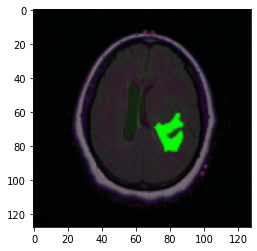

In [82]:
plt.imshow(y_val_with_mask[6])

### Unet segmentation

In [83]:
# Build U-Net model


inputs = Input((128, 128, 3))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

UNet = Model(inputs=[inputs], outputs=[outputs])
UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef_loss])
UNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 128, 128, 16) 0           conv2d_104[0][0]                 
____________________________________________________________________________________________

In [84]:
# Fit model
checkpoint_filepath_unet = 'E:/AI_ML_DL/week 8/Brain-Tumor/bestmodel_unet'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_unet,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

results = UNet.fit(X_train_with_mask, y_train_with_mask, validation_data=(X_val_with_mask,y_val_with_mask),batch_size=16, epochs=50, 
                    callbacks=[mc, es])

Epoch 1/50
70/70 [==============================] - 5s 39ms/step - loss: 0.4061 - dice_coef_loss: 0.0698 - val_loss: 0.2578 - val_dice_coef_loss: 0.0229
Epoch 2/50
70/70 [==============================] - 2s 31ms/step - loss: 0.2580 - dice_coef_loss: 0.0233 - val_loss: 0.2516 - val_dice_coef_loss: 0.0185
Epoch 3/50
70/70 [==============================] - 2s 28ms/step - loss: 0.2501 - dice_coef_loss: 0.0194 - val_loss: 0.2450 - val_dice_coef_loss: 0.0156
Epoch 4/50
70/70 [==============================] - 2s 29ms/step - loss: 0.2466 - dice_coef_loss: 0.0177 - val_loss: 0.2423 - val_dice_coef_loss: 0.0149
Epoch 5/50
70/70 [==============================] - 2s 28ms/step - loss: 0.2431 - dice_coef_loss: 0.0159 - val_loss: 0.2425 - val_dice_coef_loss: 0.0141
Epoch 6/50
70/70 [==============================] - 2s 29ms/step - loss: 0.2404 - dice_coef_loss: 0.0144 - val_loss: 0.2403 - val_dice_coef_loss: 0.0144
Epoch 7/50
70/70 [==============================] - 2s 29ms/step - loss: 0.2374 - 

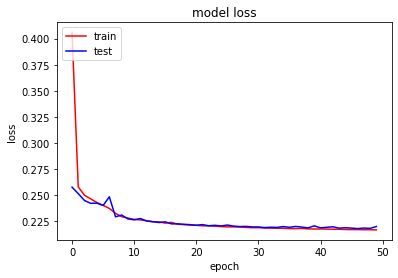

In [85]:
# Loss 
plt.plot(results.history['loss'],'r')
plt.plot(results.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
print(UNet.evaluate(X_test_with_mask,y_test_with_mask))

5/5 [==============================] - 0s 46ms/step - loss: 0.2192 - dice_coef_loss: 0.0022
[0.21921084821224213, 0.0022359206341207027]


(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)


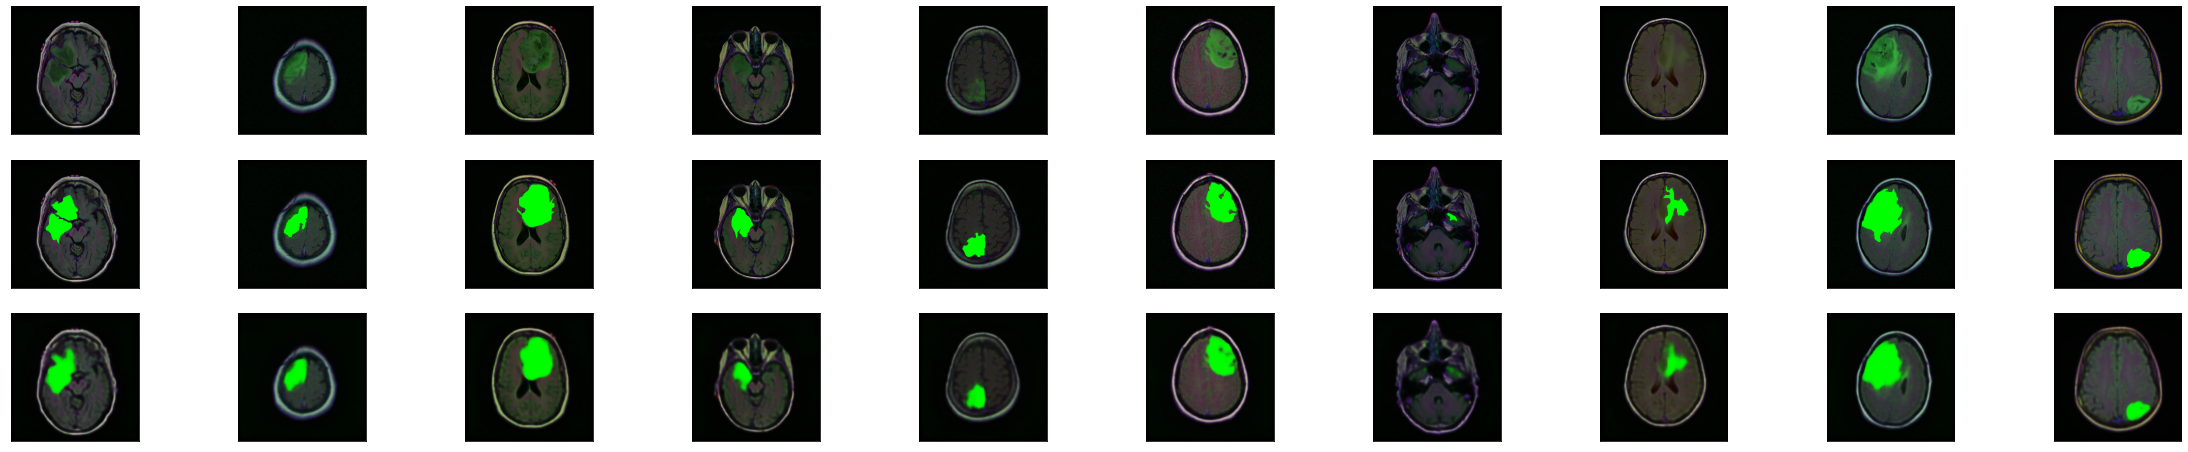

In [87]:
# Testing
# Loading the the best performing model
UNet.load_weights(checkpoint_filepath_unet)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
UNet.save("./Model/UNet.h5")

decoded_imgs = UNet.predict(X_test_with_mask)
print(X_test_with_mask.shape)
n = 10 # number of images to plot
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Originals mask
    ax = plt.subplot(3, n, i + 1+ n)
    print(X_test_with_mask.shape)
    plt.imshow(y_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(3, n, i + 1 + n +n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### DeepLabPlus (multi-class segmentation) ResNet50 pretrained on ImageNet as the backbone model

Atrous Spatial Pyramid Pooling (ASSP) is a semantic segmentation module for resampling a given feature layer at multiple rates prior to convolution. This amounts to probing the original image with multiple filters that have complementary effective fields of view, thus capturing objects as well as useful image context at multiple scales. Rather than actually resampling features, the mapping is implemented using multiple parallel atrous convolutional layers with different sampling rates.

In [88]:
from tensorflow.keras.applications import ResNet50

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=64, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=64, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=64, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=64, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=64, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=64, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    inputs = Input(shape)

    # Pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Pre-trained ResNet50 Output 
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    # Get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # Outputs
    x = Conv2D(3, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    # Model 
    DeepLabPlus1 = Model(inputs=inputs, outputs=x)
    return DeepLabPlus1

if __name__ == "__main__":
    input_shape = (image_size, image_size, 3)
    DeepLabPlus1 = DeepLabV3Plus(input_shape)
    DeepLabPlus1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [89]:
# Fit model
checkpoint_filepath_deeplabplus = './bestmodel_deeplabplus'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_deeplabplus,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
DeepLabPlus1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', metrics=[dice_coef_loss],
)

history = DeepLabPlus1.fit(X_train_with_mask,y_train_with_mask,validation_data=(X_val_with_mask,y_val_with_mask),batch_size=16, epochs=80,callbacks=[mc, es])


Epoch 1/80
70/70 [==============================] - 13s 114ms/step - loss: 0.3133 - dice_coef_loss: 0.0527 - val_loss: 0.3570 - val_dice_coef_loss: 0.0830
Epoch 2/80
70/70 [==============================] - 6s 89ms/step - loss: 0.2346 - dice_coef_loss: 0.0091 - val_loss: 0.3230 - val_dice_coef_loss: 0.0596
Epoch 3/80
70/70 [==============================] - 6s 92ms/step - loss: 0.2267 - dice_coef_loss: 0.0067 - val_loss: 0.3495 - val_dice_coef_loss: 0.0782
Epoch 4/80
70/70 [==============================] - 6s 90ms/step - loss: 0.2244 - dice_coef_loss: 0.0060 - val_loss: 0.3310 - val_dice_coef_loss: 0.0665
Epoch 5/80
70/70 [==============================] - 6s 89ms/step - loss: 0.2230 - dice_coef_loss: 0.0055 - val_loss: 0.3281 - val_dice_coef_loss: 0.0627
Epoch 6/80
70/70 [==============================] - 6s 90ms/step - loss: 0.2222 - dice_coef_loss: 0.0052 - val_loss: 0.3331 - val_dice_coef_loss: 0.0677
Epoch 7/80
70/70 [==============================] - 6s 89ms/step - loss: 0.2217 

In [90]:
print(DeepLabPlus1.evaluate(X_test_with_mask,y_test_with_mask))

5/5 [==============================] - 1s 92ms/step - loss: 0.2215 - dice_coef_loss: 0.0043
[0.22150744497776031, 0.0042812405154109]


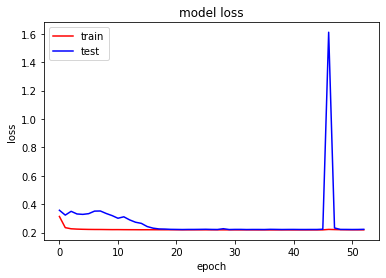

In [91]:
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)


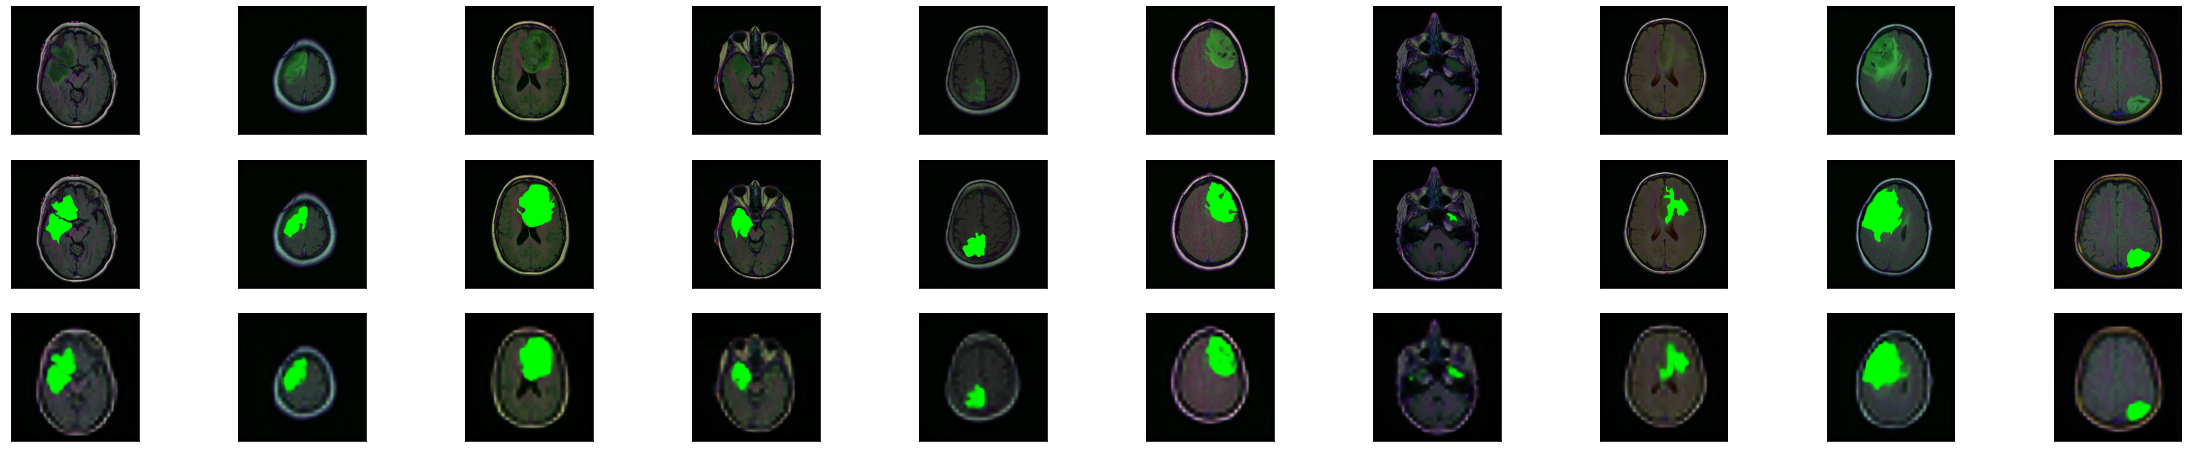

In [92]:
# Testing
# Loading the the best performing model
DeepLabPlus1.load_weights(checkpoint_filepath_deeplabplus)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
DeepLabPlus1.save("./Model/DeepLabPlus1.h5")


decoded_imgs = DeepLabPlus1.predict(X_test_with_mask)
print(X_test_with_mask.shape)
n = 10 # number of images to plot
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Originals mask
    ax = plt.subplot(3, n, i + 1+ n)
    print(X_test_with_mask.shape)
    plt.imshow(y_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(3, n, i + 1 + n +n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

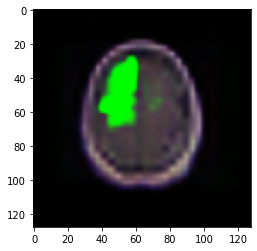

In [93]:
 plt.imshow(decoded_imgs[15])

# Current training arrays

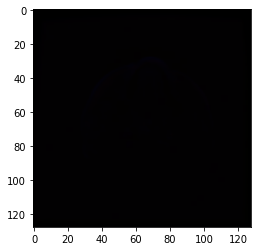

In [94]:
# with and without mask -> but the mask is not pasted on it
plt.imshow(X_train[1])

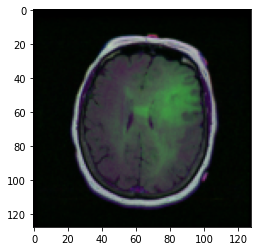

In [95]:
# means that there are only brains with tumors
plt.imshow(X_train_with_mask[1])

In [96]:
print(y_train.shape)
# tumor mask ->> categorical
y_train[50]

(2100, 2)


array([0., 1.], dtype=float32)

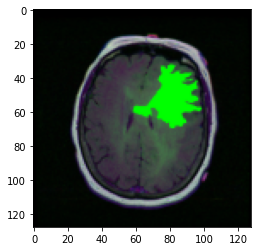

In [97]:

# brain with tumor mask on
plt.imshow(y_train_with_mask[1])

## Applicatie 

A list of images that first go throught the classification part. If the model predictics that the image contains a tumor, then it will been forwarded to the segmentation model.

In [163]:
# Dice coefficient loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### list images


In [164]:

path_test = "../input/test-images/"
# path_test = "E:/AI_ML_DL/week 8/Brain-Tumor/brain-tumour-dataset/kaggle_3m"

# Separate images and masks in the directory
masks_dir = glob.glob(path_test + "*_mask*")



In [165]:
mask_dir = []
for masks in masks_dir:
    mask = imread(masks)
    mask_dir.append(mask)

In [166]:
images_dir = []
for img in masks_dir:
    images_dir.append(img.replace("_mask", ""))

In [167]:
images = images_dir

### Output

In [168]:
# read model
OwnClassificationNN = keras.models.load_model('E:/AI_ML_DL/week 8/Brain-Tumor/Model/OwnClassificationNN_aug.h5')
# OwnClassificationNN_aug.save("./Model/OwnClassificationNN_aug.h5")
segmentationmodel = keras.models.load_model('E:/AI_ML_DL/week 8/Brain-Tumor/Model/UNet.h5', custom_objects={"dice_coef_loss": dice_coef_loss })

if len(images) > 1:
    #resize to 128
    image_size = 128
    images_resized = []
    i = 0
    #reading images & resize 
    for image in images:
        image = imread(images[i])
       
        #resize
        resized = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        images_resized.append(resized)
        
        i += 1
        if i > len(images):
            break
        
    images = images_resized
    images = np.asarray(images)
    print(images.shape)
    
    # classification
    # (if tumor -> forward to segmantation model)
    # (if not -> show images and state that no tumor was found.
    class1 = []
    class0 = []
    mask1 = []
    mask0 = []
    i = 0
    for eachImage in images:
        eachImage = np.asarray(eachImage)
        eachImage = eachImage.reshape(1,image_size, image_size,3)
    
        #prediction class
        predictionClassification = OwnClassificationNN.predict(eachImage)
        predictionClassification = np.argmax(predictionClassification)
        
        print(predictionClassification)
        if predictionClassification == 1:
            mask1.append(mask_dir[i])
            
            # Segmentation
            predictionSegmentation = segmentationmodel.predict(eachImage)
            #print("Segmentation: ",segmentationmodel)

            predictionSegmentation = predictionSegmentation.reshape(image_size, image_size,3)
            
            class1.append(predictionSegmentation)            
        else:
            eachImage = eachImage.reshape(image_size, image_size,3)
            #add mask to array so it stays in correct order
            mask0.append(mask_dir[i])
            #append image without tumor
            class0.append(eachImage)
            
        i += 1
        if i > len(images):
            break



(4, 128, 128, 3)
1
0
1
0


### List - No tumor detected

(275, 128, 128, 3)
(275, 128, 128, 3)


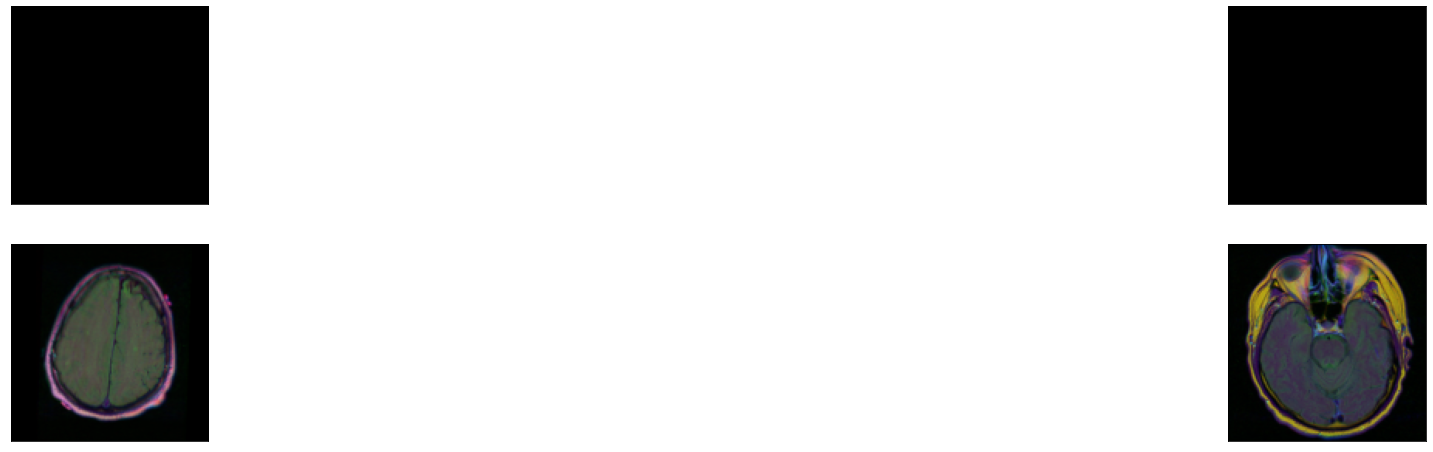

In [169]:
n = len(mask0) 
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals mask
    ax = plt.subplot(2, n, i + 1)
    print(X_test.shape)
    plt.imshow(mask0[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n )
    plt.imshow(class0[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### List -  Tumor detected

(275, 128, 128, 3)
(275, 128, 128, 3)


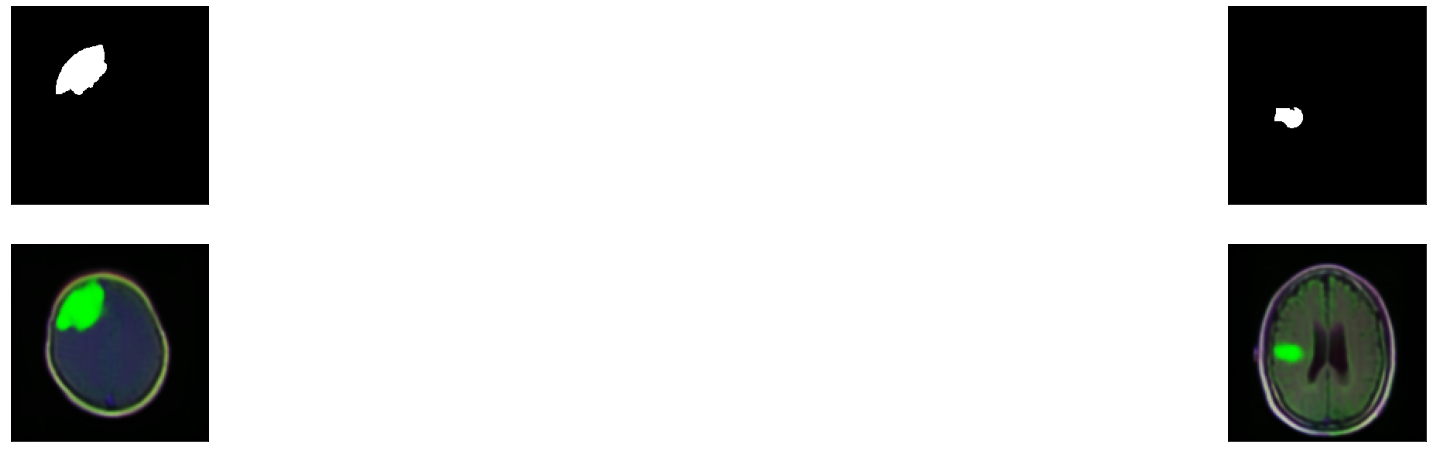

In [170]:
n = len(mask1) 
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals mask
    ax = plt.subplot(2, n, i + 1)
    print(X_test.shape)
    plt.imshow(mask1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n )
    plt.imshow(class1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()